# Flower Classfication

## Flower Classification

Image classification is a core and fundamental task in computer vision.

We will implement a multi-class image classifier to recognize flowers.

We will design and train a deep convolutional network from scratch to predict the class label of a flower image. This will help you gain experience with network design and get more familiar with PyTorch.

## Google Colab Setup
First, we need to run a few commands to set up our environment on Google Colab. Can skip this section if running this notebook on a local machine.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Versions of used packages

Check PyTorch version to make sure everything work properly.

We use `python==3.7.14`, `torch==1.12.1+cu113` and `torchvision==0.13.1+cu113`. This is the default version in Google Colab.

In [ ]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.7.15 (default, Oct 12 2022, 19:14:55) 
torch 1.12.1+cu113
torchvision 0.13.1+cu113


## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。
> The reason of this error is over-sized batch_size or unreleased memory. If changing the batch_size smaller still cause this error. Please reload colab follow below instructions.

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk



# Prepare Data

We use [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset which is collected by Alexander Mamaev.

**Abstrct**  

This dataset contains 4317 flower images.  
But, we only use 1724(40%) images here.

The data collection is grabed from the data flicr, google images, yandex images.
We use this datastet to recognize plants from the photo.

The pictures are divided into five classes: 
+ daisy
+ tulip
+ rose
+ sunflower
+ dandelion

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## How to Get Data

Please open the file `A3_data_flower_2022.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/1BKAws4gdgf8yAvkIao2nWZgtJ30FjPH4/view?usp=sharing)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

## Unzip Data

Unzip `A3_data_flower_2022.zip`, there are 2 folders and 3 csvs.

- `train/`: contains 5 folders for 5 categories of flowers. Images of flowers inside them.
- `test/`: unclassified images of testing set.
- `train.csv`: file path and true label of training set.
- `val.csv`: file path and true label of validation set.
- `train.csv`: file paht of testing set.

There are **1296 images in dataset_train.**  
There are **432 images in dataset_test.**  
There are **431 images in dataset_val.**

In [ ]:
!unzip -qq ./drive/My\ Drive/A3_data_flower_2022.zip

replace A3_data_flower_2022/val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
data_folder = 'A3_data_flower_2022'

## Loading the dataset


### Custom dataset

Build a classs inherit `torch.utils.data.Dataset`.  
Implement `__init__`, `__getitem__` and `__len__` 3 functions.  

Some operations could be there: setting location of dataset, the method of reading data, label of dataset or transform of dataset.

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [ ]:
import csv
import os
import numpy as np
from PIL import Image
import torch

class FlowerData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.labels = []
        self.transform = transform
        
        with open(f'{data_folder}/{csv_file}', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(f"{data_folder}/{row['file_path']}")
                if mode != 'test':
                    self.labels.append(row['label'])

    def __getitem__(self, index):
        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        label = torch.tensor(int(self.labels[index]))

        return data, label

    def __len__(self):
        return len(self.data_list)

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/vision/stable/transforms.html)

**NOTICE**: There are some operations may not be necessary for predict, so we should write one for train and one for others.

In [ ]:
from torchvision import transforms
# For TRAIN
transforms_train = transforms.Compose([
    transforms.Resize((256,256)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.RandomCrop(224),
    
    transforms.ColorJitter(brightness = 0.5),
    transforms.RandomGrayscale(p = 0.5),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees=(-90, 90)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2023, 0.1994, 0.2010])
])

# For VAL, TEST
transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    
    # transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2023, 0.1994, 0.2010])
])

### Instantiate dataset

Let's instantiate three `FlowerData` class.
+ dataset_train: for training.
+ dataset_val: for validation.
+ dataset_test: for tesing.

In [ ]:
dataset_train = FlowerData('train.csv', mode='train', transform=transforms_train)
dataset_val = FlowerData('val.csv', mode='val', transform=transforms_test)
dataset_test = FlowerData('test.csv', mode='test', transform=transforms_test)

In [ ]:
print("The first image's shape in dataset_train :", dataset_train[0][0].size())
print("There are", len(dataset_train), "images in dataset_train.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 3022 images in dataset_train.


### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
num_workers = 2
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

# Implement CNN using PyTorch

### Define a Convolutional Neural Network

Design and train a deep convolutional network from scratch to predict the class label of a flower image.

In [ ]:
import torch.nn as nn 
import torch.nn.functional as F

class YourCNNModel(nn.Module): 
    def __init__(self): 
        super().__init__()
        
        # generate a CNN model part             
        # input dimension will be influenced by the data augementation process
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.fc= nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(),

            nn.Linear(1000, 5)
        )

    def forward(self, x): 
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
      
        out = self.conv(x)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
      
        return out

In [ ]:
device = torch.device('cuda')
# or
# device = torch.device('cpu')

In [ ]:
model = YourCNNModel()
model = model.to(device)
# print(model)

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
We can define them in one-line.

### Define loss and optimizer

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # cause the output by the last layer aren't prob.
params = model.parameters() # call a method of model to get parameters
optimizer = torch.optim.Adam(params, lr=0.0001)  # throw param into optimizer some_optimier(param, lr=...)

criterion = criterion.to(device)

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

In [ ]:
# the input_data which processed by DataLoader, batch.size of each will be like -> [(32 / 64 / 128), 3, 224, 224]

def train(input_data, model, criterion, optimizer):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''

    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    for images, labels in input_data:
        images = images.to(device)
        labels = labels.to(device)
        
        # 1. zero the parameter gradients                                      #
        # 2. process input through the network                                 #
        # 3. compute the loss                                                  #
        # 4. propagate gradients back into the network’s parameters            #
        # 5. Update the weights of the network                                 #
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        # 1. get the model predicted result                                    #
        # 2. sum the number of this batch predicted images                     #
        # 3. sum the number of correctly classified                            #
        # 4. save this batch's loss into loss_list                             #
        # dimension of outputs: [batch_size, number of classes]                #
        _, predicted = torch.max(out.data, 1) # the class with the highest value is what we choose as prediction
        total_count += labels.size(0)
        acc_count += (predicted == labels).sum().item()
        loss_list.append(loss.item())

    # Compute this epoch accuracy and loss
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [ ]:
def val(input_data, model, criterion):
    model.eval()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for images, labels in input_data:
            images = images.to(device)
            labels = labels.to(device)

            # 1. process input through the network                             #
            # 2. compute the loss                                              #
            # 3. get the model predicted result                                #
            # 4. get the counts of correctly classified images                 #
            # 5. save this batch's loss into loss_list                         #
            out = model(images)
            loss = criterion(out, labels)

            _, predicted = torch.max(out.data, 1)
            total_count += labels.size(0)
            acc_count += (predicted == labels).sum().item()
            loss_list.append(loss.item())

    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

In [ ]:
import numpy as np
import torch

# Apply EarlyStop to avoid overfitting problem

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [ ]:
max_epochs = 150
log_interval = 10 # print acc and loss in per log_interval time

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

early_stopping = EarlyStopping(patience=20, verbose=True)

for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = val(val_loader, model, criterion)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))

    early_stopping(val_loss, model)
        
    if early_stopping.early_stop:
      print("Early stopping")
      break

Validation loss decreased (inf --> 1.275678).  Saving model ...
Validation loss decreased (1.275678 --> 1.245309).  Saving model ...
Validation loss decreased (1.245309 --> 1.094441).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (1.094441 --> 1.010641).  Saving model ...
Validation loss decreased (1.010641 --> 0.997703).  Saving model ...
Validation loss decreased (0.997703 --> 0.957869).  Saving model ...
Validation loss decreased (0.957869 --> 0.935972).  Saving model ...
==================== Epoch 10 ====================
Train Acc: 0.560887 Train Loss: 1.082139
  Val Acc: 0.602549   Val Loss: 0.954778
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (0.935972 --> 0.913090).  Saving model ...
Validation loss decreased (0.913090 --> 0.881272).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
Valida

In [ ]:
# save your well-trained state_dict of model (no need to run the cell here if you apply earlystop method)
# torch.save(model.state_dict(), 'NAME_OF_THIS_EXPERIMENT.pt')

#### Visualize accuracy and loss

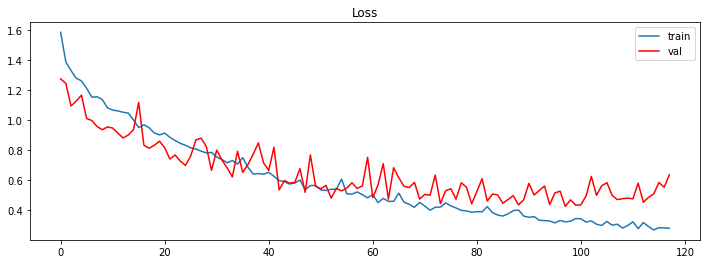

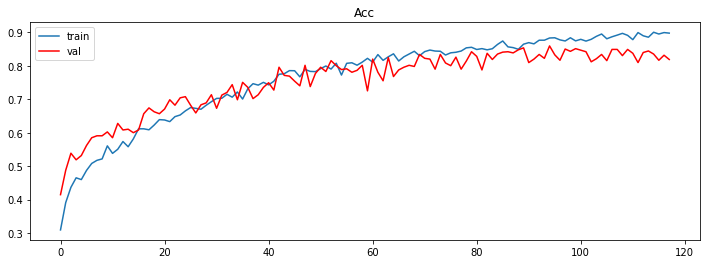

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()

### Predict Result

In [ ]:
# # if you wanna load previous best model
ckpt = torch.load('checkpoint.pt') # change the file name of the model if nesse
model.load_state_dict(ckpt) 

<All keys matched successfully>

In [ ]:
def predict(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for images in input_data:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [ ]:
idx = 0
output_csv = predict(test_loader, model)
with open('result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'label'])
    writer.writeheader()
    for result in output_csv:
        file_path = dataset_test.data_list[idx].replace(data_folder + '/', '')
        writer.writerow({'file_path':file_path, 'label':result})
        idx += 1